In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [3]:
ROOT = '/home/robert/DataSpellProjects/marchMadness/Data'
Train = pd.read_csv(f'{ROOT}/Train.csv')
TeamIDs = pd.read_csv(f'{ROOT}/MTeams.csv')
Rankings = pd.read_csv(f'{ROOT}/MMasseyOrdinals.csv')
Train.drop(columns=['Unnamed: 0'], inplace=True)
Train

,Season,Team1,Team2,Team1 Rank,Team2 Rank,Team1 Win%,Team2 Win%,Team1 Avg Pts,Team2 Avg Pts,Team1 Avg Pts A,...,Team1 DR,Team2 DR,Team1 DR A,Team2 DR A,Team1 TO,Team2 TO,Team1 TA,Team2 TA,Team1 Pts,Team2 Pts
0,2003,1411,1421,236.217500,241.370000,0.600000,0.448276,72.800000,71.206897,70.833333,...,24.800000,23.172414,22.866667,22.827586,15.233333,16.206897,14.333333,12.827586,84,92
1,2003,1112,1436,3.676744,171.797500,0.892857,0.655172,85.214286,67.793103,70.250000,...,27.642857,25.724138,23.285714,21.862069,14.785714,14.068966,16.857143,13.000000,80,51
2,2003,1272,1113,42.000000,40.892500,0.793103,0.620690,74.517241,75.965517,65.827586,...,25.965517,23.310345,23.586207,20.551724,13.793103,14.000000,15.068966,15.517241,71,84
3,2003,1166,1141,16.869767,75.095000,0.878788,0.793103,79.242424,79.344828,64.333333,...,23.181818,23.275862,21.363636,18.896552,13.363636,18.241379,17.060606,16.068966,73,79
4,2003,1301,1143,55.451613,40.748184,0.600000,0.724138,72.400000,74.482759,68.000000,...,22.033333,24.379310,21.433333,23.000000,14.200000,14.172414,14.633333,14.931034,74,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,1425,1211,22.856918,1.500747,0.758621,1.000000,74.758621,92.115385,65.103448,...,25.827586,27.269231,21.068966,20.884615,12.103448,11.923077,11.000000,14.461538,66,85
1177,2021,1417,1276,38.442700,6.533835,0.653846,0.833333,72.846154,76.250000,68.500000,...,24.192308,27.083333,21.461538,21.166667,10.884615,10.666667,11.153846,9.500000,51,49
1178,2021,1124,1222,2.440957,6.653214,0.916667,0.884615,84.375000,76.307692,66.416667,...,22.375000,24.769231,20.125000,19.653846,12.166667,10.153846,16.833333,13.807692,78,59
1179,2021,1211,1417,1.500747,38.442700,1.000000,0.653846,92.115385,72.846154,69.115385,...,27.269231,24.192308,20.884615,21.461538,11.923077,10.884615,14.461538,11.153846,93,90


In [4]:
def get_team_name(team_id):
    return TeamIDs.loc[TeamIDs['TeamID']==team_id]['TeamName'].values[0]

In [5]:
def get_team_id(team_name):
    return TeamIDs.loc[TeamIDs['TeamName']==team_name]['TeamID'].values[0]

## Find and Fix Skewed Features

In [6]:
for col in Train.columns:
    skew = Train[col].skew()
    if abs(skew) > 1:
        print(f'{col}: {round(skew, 3)}')

Team1 Rank: 2.22
Team2 Rank: 2.137


This makes sense, stats like score per game, win%, etc. are expected for fall into a normal distribution. However, the team ranks are an average of polls, rankings, etc. so, they won't fall into a normal distribution.

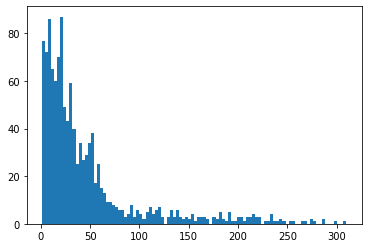

In [7]:
plt.hist(Train['Team1 Rank'], bins=100)
plt.show()

In [8]:
Train['Team1 Rank'] = np.log1p(Train['Team1 Rank'])
Train['Team2 Rank'] = np.log1p(Train['Team2 Rank'])

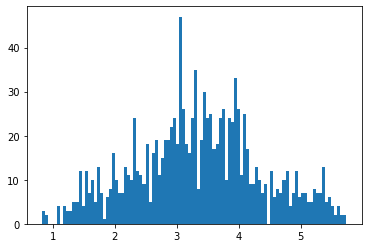

In [9]:
plt.hist(Train['Team1 Rank'], bins=100)
plt.show()

## Scale & Split Data

In [10]:
scale_columns = []
features = []
predict = ['Team1 Pts', 'Team2 Pts']
no_scale = ['Season', 'Team1', 'Team2', 'Team1 Pts', 'Team2 Pts']
for col in Train.columns:
    if col not in no_scale:
        features.append(col)
        scale_columns.append(col)
scaler = MinMaxScaler()
Train[scale_columns] = scaler.fit_transform(Train[scale_columns])

In [11]:
X_train = Train[Train.Season < 2021]
X_train = X_train[features]
y_train = Train[Train.Season < 2021]
y_train = y_train[predict]
X_test = Train[Train.Season == 2021]
X_test = X_test[features]
y_test = Train[Train.Season == 2021]
y_test = y_test[predict]

In [12]:
svr = SVR()
regr = MultiOutputRegressor(svr)
regr.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR())

In [13]:
def get_winner(team1_name, team2_name, year):
    team1 = get_team_id(team1_name)
    team2 = get_team_id(team2_name)
    team1_cols = []
    team2_cols = []
    for col in X_train.columns:
        if 'Team1' in col:
            team1_cols.append(col)
        else:
            team2_cols.append(col)
    row1 = []
    row2 = []
    return_row = []
    #check tha team1 and team2 have data for that year
    if (team1 not in Train['Team1'].values) and (team1 not in Train['Team2'].values):
        print("Can't find team1 data")
        raise IndexError
    if (team2 not in Train['Team1'].values) and (team2 not in Train['Team2'].values):
        print("Can't find team2 data")
        raise IndexError
    for col in team1_cols:
        try:
            row1.append(Train[Train.Season==year].loc[Train['Team1']==team1][col].values[0])
        except IndexError:
            row1.append(Train[Train.Season==year].loc[Train['Team2']==team1][col].values[0])
    for col in team2_cols:
        try:
            row2.append(Train[Train.Season==year].loc[Train['Team1']==team2][col].values[0])
        except IndexError:
            row2.append(Train[Train.Season==year].loc[Train['Team2']==team2][col].values[0])
    count = 0
    for i in range(len(row1)):
        return_row.append(row1[count])
        return_row.append(row2[count])
        count += 1
    df = pd.DataFrame([return_row], columns=X_train.columns)
    prediction = regr.predict(df)
    prediction = pd.DataFrame(prediction, columns=['Team1', 'Team2'])
    if prediction['Team1'].values[0] > prediction['Team2'].values[0]:
        return team1_name, f"+{round((prediction['Team1'].values[0]-prediction['Team2'].values[0]) * 2 / 2)}"
    else:
        return team2_name, f"+{round((prediction['Team2'].values[0]-prediction['Team1'].values[0]) * 2 / 2)}"

In [14]:
get_winner('Michigan', 'LSU', 2021)

('Michigan', '+3')